## 验证2次hash是否影响分片数据不均衡

按照生产数据量预估，每个物理库的数据分片设为32，如下SQL语句。需要探讨的是2次hash会不会引起分片数据不均衡。

```

CREATE TABLE IF NOT EXISTS `coupon` (
    ...
    `uid` varchar(32) NOT NULL DEFAULT '' ,
    `shard_id` bigint NOT NULL DEFAULT 0 
    ...
) ENGINE=InnoDB DEFAULT CHARSET=utf8 dbpartition by hash(shard_id) tbpartition by hash(shard_id) tbpartitions 32;
// ) ENGINE=InnoDB DEFAULT CHARSET=utf8 dbpartition by hash(uid) tbpartition by hash(uid) tbpartitions 32;
    
```

1. 一次hash：根据uid分片，只有一次数据库分片hash。
1. 二次hash：根据uid的hash分片，数据库分片hash，加uid hash。

ShardID = Hash1(UID) % 10000

PartionedDBId = Hash2 ( ShardID ) % 32


以下假设数据库中间件对分片键的hash算法为SHA256。实际效果以压测后的报告为准。

In [1]:
import hashlib
import uuid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (20, 3)

In [3]:
def sha256(text):
    return hashlib.sha256(text).hexdigest()

def gen_shard_id(text):
    return int(sha256(text)[:4], 16) % 10000

def gen_partition_id(text):
    return int(sha256(text)[:2], 16) % 32

In [4]:
class SerialGenerator:
    def __init__(self, size):
        self.size = size
        self.offset = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.offset == self.size:
            raise StopIteration

        self.offset += 1
        return "u_{0:012d}".format(self.offset)


class RandomGenerator:
    def __init__(self, size):
        self.size = size
        self.offset = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.offset == self.size:
            raise StopIteration

        self.offset += 1
        return str(uuid.uuid4())

In [5]:
# def plot_hist_10k(arr):
#     plt.subplot(121)
#     plt.hist(arr, bins=10000)
#     plt.title('hist')

# def plot_hist_32(arr):
#     plt.subplot(122)
#     plt.hist(arr, bins=32)
#     plt.title('hist')
    
def plot_hist(arr, subplot, title):
    plt.subplot(subplot)
    plt.hist(arr, bins=32)
    plt.title(title)

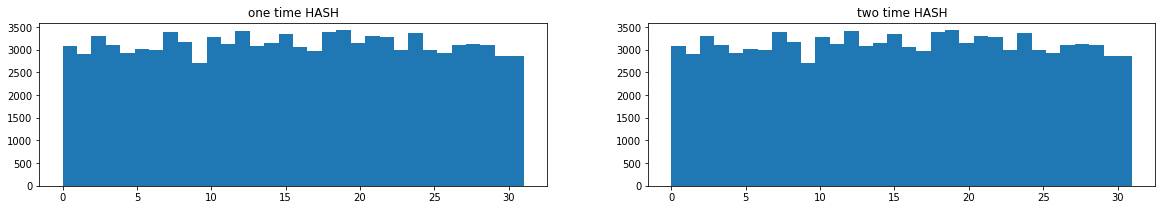

In [6]:
# shard_id_list = []
partition_id_list = []
partition_id_list2 = []

# for uid in RandomGenerator(100000):
for uid in SerialGenerator(100000):
    shard_id = gen_shard_id(uid.encode())
#     shard_id_list.append(shard_id)
    
    partition_id = gen_partition_id(str(shard_id).encode())
    partition_id_list.append(partition_id)
    
    partition_id2 = gen_partition_id(uid.encode())
    partition_id_list2.append(partition_id)
#     print(uid, shard_id, partition_id)

# plot_hist_10k(shard_id_list)
plot_hist(partition_id_list2, 121, "one time HASH")
plot_hist(partition_id_list, 122, "two time HASH")